# Visualize phylogenetic trees

Import Python packages:

In [1]:
import math
import os

import pandas as pd

import ete3

/fh/fast/bloom_j/software/miniconda3/envs/ete3/lib/python3.8/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
/fh/fast/bloom_j/software/miniconda3/envs/ete3/lib/python3.8/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


Get variables from `snakemake`:

In [2]:

######## snakemake preamble start (automatically inserted, do not edit) ########
import sys; sys.path.extend(['/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2_PRJNA612766/lib/python3.8/site-packages', '/home/jbloom/SARS-CoV-2_PRJNA612766/notebooks']); import pickle; snakemake = pickle.loads(b"\x80\x04\x95\xab'\x00\x00\x00\x00\x00\x00\x8c\x10snakemake.script\x94\x8c\tSnakemake\x94\x93\x94)\x81\x94}\x94(\x8c\x05input\x94\x8c\x0csnakemake.io\x94\x8c\nInputFiles\x94\x93\x94)\x81\x94(\x8c)results/phylogenetics/all_RaTG13.treefile\x94\x8c)results/phylogenetics/all_RpYN06.treefile\x94\x8c)results/phylogenetics/all_RmYN02.treefile\x94\x8c,results/phylogenetics/region_RaTG13.treefile\x94\x8c,results/phylogenetics/region_RpYN06.treefile\x94\x8c,results/phylogenetics/region_RmYN02.treefile\x94e}\x94(\x8c\x06_names\x94}\x94(\x8c\ttrees_all\x94K\x00K\x03\x86\x94\x8c\x0ctrees_region\x94K\x03K\x06\x86\x94u\x8c\x12_allowed_overrides\x94]\x94(\x8c\x05index\x94\x8c\x04sort\x94eh\x19\x8c\tfunctools\x94\x8c\x07partial\x94\x93\x94h\x06\x8c\x19Namedlist._used_attribute\x94\x93\x94\x85\x94R\x94(h\x1f)}\x94\x8c\x05_name\x94h\x19sNt\x94bh\x1ah\x1dh\x1f\x85\x94R\x94(h\x1f)}\x94h#h\x1asNt\x94bh\x13h\x06\x8c\tNamedlist\x94\x93\x94)\x81\x94(h\nh\x0bh\x0ce}\x94(h\x11}\x94h\x17]\x94(h\x19h\x1aeh\x19h\x1dh\x1f\x85\x94R\x94(h\x1f)}\x94h#h\x19sNt\x94bh\x1ah\x1dh\x1f\x85\x94R\x94(h\x1f)}\x94h#h\x1asNt\x94bubh\x15h*)\x81\x94(h\rh\x0eh\x0fe}\x94(h\x11}\x94h\x17]\x94(h\x19h\x1aeh\x19h\x1dh\x1f\x85\x94R\x94(h\x1f)}\x94h#h\x19sNt\x94bh\x1ah\x1dh\x1f\x85\x94R\x94(h\x1f)}\x94h#h\x1asNt\x94bubub\x8c\x06output\x94h\x06\x8c\x0bOutputFiles\x94\x93\x94)\x81\x94\x8c\x0btree_images\x94a}\x94(h\x11}\x94h\x17]\x94(h\x19h\x1aeh\x19h\x1dh\x1f\x85\x94R\x94(h\x1f)}\x94h#h\x19sNt\x94bh\x1ah\x1dh\x1f\x85\x94R\x94(h\x1f)}\x94h#h\x1asNt\x94bub\x8c\x06params\x94h\x06\x8c\x06Params\x94\x93\x94)\x81\x94]\x94(\x8c\x06RaTG13\x94\x8c\x06RpYN06\x94\x8c\x06RmYN02\x94ea}\x94(h\x11}\x94\x8c\toutgroups\x94K\x00N\x86\x94sh\x17]\x94(h\x19h\x1aeh\x19h\x1dh\x1f\x85\x94R\x94(h\x1f)}\x94h#h\x19sNt\x94bh\x1ah\x1dh\x1f\x85\x94R\x94(h\x1f)}\x94h#h\x1asNt\x94bh]hWub\x8c\twildcards\x94h\x06\x8c\tWildcards\x94\x93\x94)\x81\x94}\x94(h\x11}\x94h\x17]\x94(h\x19h\x1aeh\x19h\x1dh\x1f\x85\x94R\x94(h\x1f)}\x94h#h\x19sNt\x94bh\x1ah\x1dh\x1f\x85\x94R\x94(h\x1f)}\x94h#h\x1asNt\x94bub\x8c\x07threads\x94K\x01\x8c\tresources\x94h\x06\x8c\tResources\x94\x93\x94)\x81\x94(K\x01K\x01e}\x94(h\x11}\x94(\x8c\x06_cores\x94K\x00N\x86\x94\x8c\x06_nodes\x94K\x01N\x86\x94uh\x17]\x94(h\x19h\x1aeh\x19h\x1dh\x1f\x85\x94R\x94(h\x1f)}\x94h#h\x19sNt\x94bh\x1ah\x1dh\x1f\x85\x94R\x94(h\x1f)}\x94h#h\x1asNt\x94bh~K\x01h\x80K\x01ub\x8c\x03log\x94h\x06\x8c\x03Log\x94\x93\x94)\x81\x94\x8c,results/logs/notebooks/visualize_trees.ipynb\x94a}\x94(h\x11}\x94\x8c\x08notebook\x94K\x00N\x86\x94sh\x17]\x94(h\x19h\x1aeh\x19h\x1dh\x1f\x85\x94R\x94(h\x1f)}\x94h#h\x19sNt\x94bh\x1ah\x1dh\x1f\x85\x94R\x94(h\x1f)}\x94h#h\x1asNt\x94bh\x92h\x8fub\x8c\x06config\x94}\x94(\x8c\x08max_cpus\x94K\x04\x8c\x0bscratch_dir\x94\x8c\x11results/_scratch/\x94\x8c\nref_genome\x94}\x94(\x8c\x05fasta\x94\x8c}ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/009/858/895/GCF_009858895.2_ASM985889v3/GCF_009858895.2_ASM985889v3_genomic.fna.gz\x94\x8c\x03gff\x94\x8c}ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/009/858/895/GCF_009858895.2_ASM985889v3/GCF_009858895.2_ASM985889v3_genomic.gff.gz\x94\x8c\x04name\x94\x8c\x07proCoV2\x94\x8c\radd_mutations\x94]\x94(\x8c\x06C8782T\x94\x8c\x07C18060T\x94\x8c\x07T28144C\x94eu\x8c\x12comparator_genomes\x94}\x94(hX}\x94\x8c\x06gisaid\x94\x8c\x0eEPI_ISL_402131\x94shY}\x94\x8c\x06gisaid\x94\x8c\x0fEPI_ISL_1699446\x94shZ}\x94\x8c\x06gisaid\x94\x8c\x0eEPI_ISL_412977\x94su\x8c\x16gisaid_comparator_dirs\x94]\x94\x8c\x1edata/comparator_genomes_gisaid\x94a\x8c\nearly_seqs\x94}\x94\x8c\x06gisaid\x94}\x94\x8c\x16gisaid_through_Feb2020\x94\x8c&data/gisaid_sequences_through_Feb2020/\x94ss\x8c\x16early_seq_header_props\x94]\x94(\x8c\x06strain\x94\x8c\x0egisaid_epi_isl\x94\x8c\x04date\x94\x8c\x11genbank_accession\x94\x8c\x07country\x94\x8c\x08location\x94\x8c\x03age\x94\x8c\x03sex\x94e\x8c\x08aligners\x94]\x94\x8c\x08minimap2\x94a\x8c\x04minq\x94K\x14\x8c\x0fmin_read_length\x94K\x14\x8c\x16consensus_min_coverage\x94K\x03\x8c\x12consensus_min_frac\x94G?\xe9\x99\x99\x99\x99\x99\x9a\x8c\x12region_of_interest\x94}\x94(\x8c\x05start\x94MBT\x8c\x03end\x94Mnsu\x8c\x16who_china_report_cases\x94\x8c(data/WHO_China_Report_Dec2019_cases.yaml\x94\x8c\x1awho_china_report_last_date\x94\x8c\x08datetime\x94\x8c\x04date\x94\x93\x94C\x04\x07\xe4\x01\x02\x94\x85\x94R\x94\x8c\x15early_seqs_to_exclude\x94\x8c\x19data/seqs_to_exclude.yaml\x94\x8c\x1dearly_seqs_ignore_muts_before\x94K\x1d\x8c\x1cearly_seqs_ignore_muts_after\x94M\x87t\x8c\x16early_seqs_filter_runs\x94}\x94(\x8c\x06n_muts\x94K\x04\x8c\x04span\x94K\nu\x8c\x17early_seqs_min_coverage\x94G?\xec\xcc\xcc\xcc\xcc\xcc\xcd\x8c\x13early_seqs_max_subs\x94K\x0f\x8c\x18early_seqs_max_ambiguous\x94M\x88\x13\x8c\x13early_seqs_max_date\x94h\xddC\x04\x07\xe4\x02\x1c\x94\x85\x94R\x94\x8c\x11min_frac_coverage\x94G?\xeeffffff\x8c\x14samples_fasterq_dump\x94}\x94\x8c\x0csamples_wget\x94}\x94(\x8c\x02A1\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313282\x94\x8c\x0bSRR11313334\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02A2\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313271\x94\x8c\x0bSRR11313461\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02A4\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313417\x94\x8c\x0bSRR11313428\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02A6\x94}\x94(\x8c\naccessions\x94]\x94\x8c\x0bSRR11313479\x94a\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02A9\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313345\x94\x8c\x0bSRR11313356\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03A11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313455\x94\x8c\x0bSRR11313456\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03A12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313473\x94\x8c\x0bSRR11313474\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02B1\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313453\x94\x8c\x0bSRR11313454\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02B2\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313451\x94\x8c\x0bSRR11313452\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02B3\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313448\x94\x8c\x0bSRR11313449\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02B4\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313322\x94\x8c\x0bSRR11313333\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02B9\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313445\x94\x8c\x0bSRR11313446\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02C1\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313287\x94\x8c\x0bSRR11313289\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02C2\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313285\x94\x8c\x0bSRR11313286\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02C9\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313441\x94\x8c\x0bSRR11313442\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03C11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313300\x94\x8c\x0bSRR11313311\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03C12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313443\x94\x8c\x0bSRR11313444\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02D9\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313436\x94\x8c\x0bSRR11313437\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03D11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313438\x94\x8c\x0bSRR11313440\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03D12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313280\x94\x8c\x0bSRR11313281\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02E1\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313276\x94\x8c\x0bSRR11313277\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02E3\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313430\x94\x8c\x0bSRR11313431\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02E5\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313274\x94\x8c\x0bSRR11313275\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02E6\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313427\x94\x8c\x0bSRR11313429\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03E11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313434\x94\x8c\x0bSRR11313435\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03E12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313432\x94\x8c\x0bSRR11313433\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02F5\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313270\x94\x8c\x0bSRR11313470\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02F8\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313423\x94\x8c\x0bSRR11313424\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03F11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313425\x94\x8c\x0bSRR11313426\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02G1\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313468\x94\x8c\x0bSRR11313469\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03G11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313421\x94\x8c\x0bSRR11313422\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03G12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313419\x94\x8c\x0bSRR11313420\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x02H9\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313464\x94\x8c\x0bSRR11313465\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03H12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313466\x94\x8c\x0bSRR11313467\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x10early outpatient\x94u\x8c\x03R01\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313409\x94\x8c\x0bSRR11313410\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R02\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313406\x94\x8c\x0bSRR11313408\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R03\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313269\x94\x8c\x0bSRR11313471\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R04\x94}\x94(\x8c\naccessions\x94]\x94\x8c\x0bSRR11313509\x94a\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R05\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313507\x94\x8c\x0bSRR11313508\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R06\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313505\x94\x8c\x0bSRR11313506\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R07\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313503\x94\x8c\x0bSRR11313504\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R08\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313500\x94\x8c\x0bSRR11313502\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R09\x94}\x94(\x8c\naccessions\x94]\x94\x8c\x0bSRR11313498\x94a\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R10\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313496\x94\x8c\x0bSRR11313497\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R11\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313494\x94\x8c\x0bSRR11313495\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R12\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313492\x94\x8c\x0bSRR11313493\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R13\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313489\x94\x8c\x0bSRR11313491\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R14\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313487\x94\x8c\x0bSRR11313488\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R15\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313485\x94\x8c\x0bSRR11313486\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94u\x8c\x03R16\x94}\x94(\x8c\naccessions\x94]\x94(\x8c\x0bSRR11313483\x94\x8c\x0bSRR11313484\x94e\x8c\x0ccollected_by\x94\x8c#Renmin Hospital of Wuhan University\x94\x8c\rpatient_group\x94\x8c\x16hospital patient (Feb)\x94uuu\x8c\x04rule\x94\x8c\x0fvisualize_trees\x94\x8c\x0fbench_iteration\x94N\x8c\tscriptdir\x94\x8c-/home/jbloom/SARS-CoV-2_PRJNA612766/notebooks\x94ub."); from snakemake.logging import logger; logger.printshellcmds = False; import os; os.chdir('/home/jbloom/SARS-CoV-2_PRJNA612766');
######## snakemake preamble end #########

snakemake.input.all_csv = 'results/phylogenetics/all_alignment.csv'
snakemake.input.region_csv = 'results/phylogenetics/region_alignment.csv'

In [3]:
outgroups = snakemake.params.outgroups

tree_files = {}
for seqregion, trees in [('all', snakemake.input.trees_all),
                         ('region', snakemake.input.trees_region),
                         ]:
    assert len(trees) == len(outgroups)
    for outgroup, tree_file in zip(outgroups, trees):
        tree_files[(seqregion, outgroup)] = tree_file
        
seq_dfs = {'all': pd.read_csv(snakemake.input.all_csv, na_filter=None),
           'region': pd.read_csv(snakemake.input.region_csv, na_filter=None)}

This next line enables Jupyter notebook rendering of trees in `ete3`:

In [4]:
# to enable jupyter notebook rendering: 
os.environ['QT_QPA_PLATFORM'] = 'offscreen'

Function get and and prettify tree:


all, RaTG13
results/phylogenetics/all_RaTG13.treefile


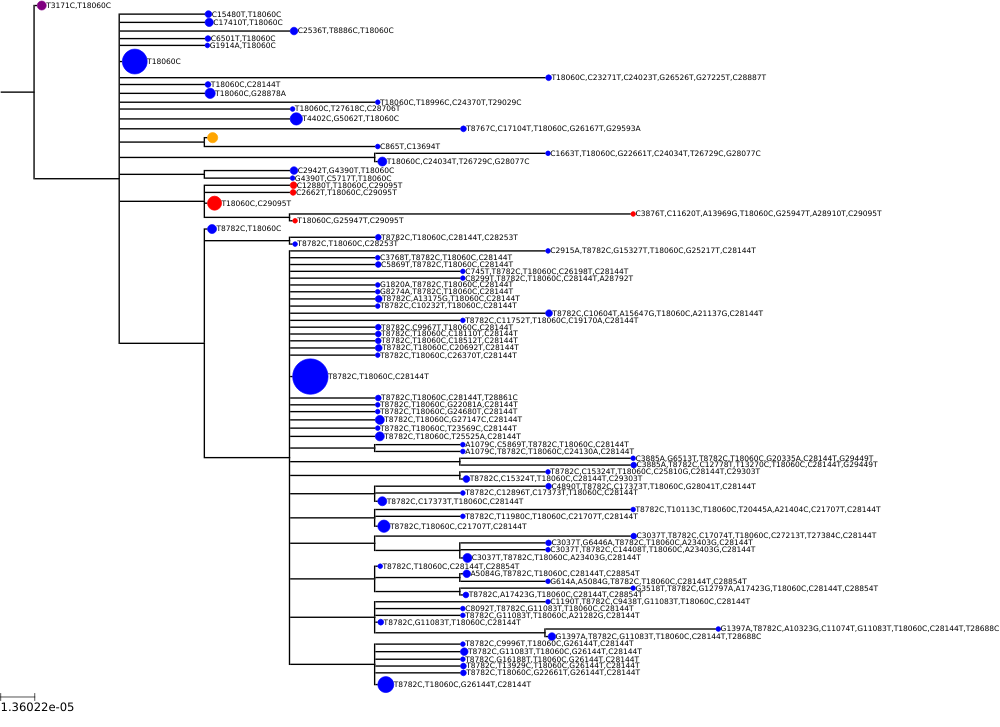


all, RpYN06
results/phylogenetics/all_RpYN06.treefile


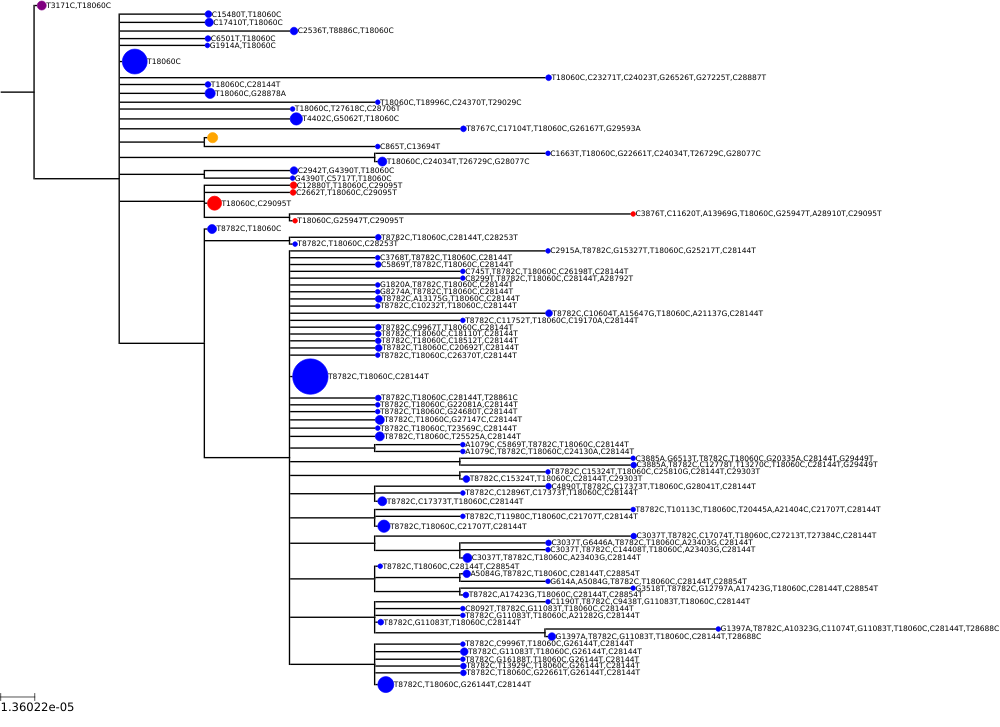


all, RmYN02
results/phylogenetics/all_RmYN02.treefile


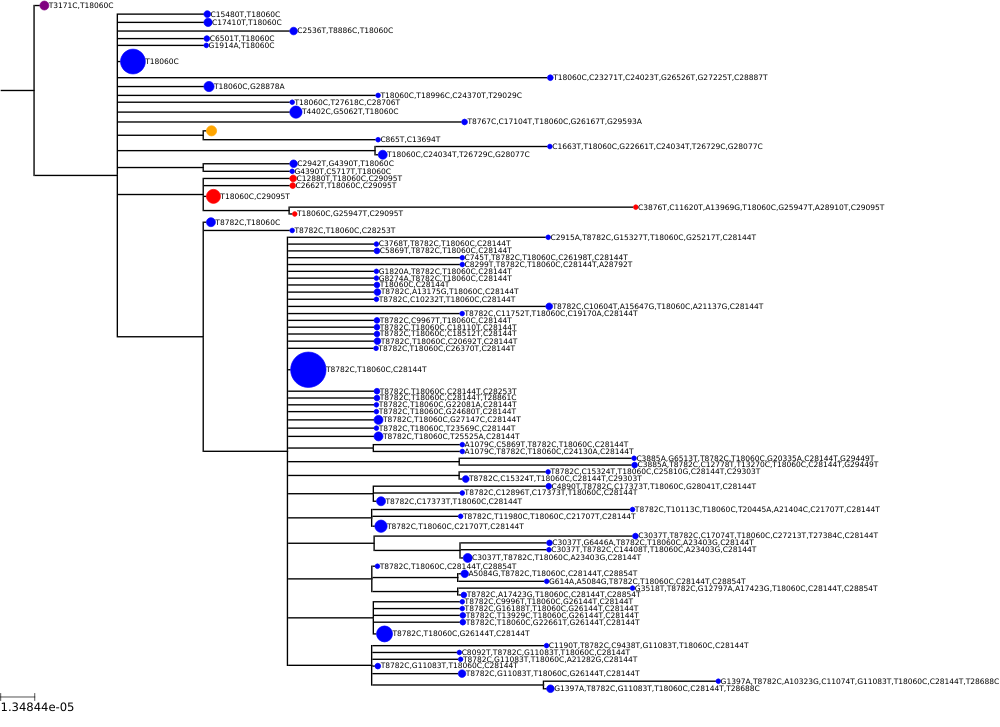


region, RaTG13
results/phylogenetics/region_RaTG13.treefile


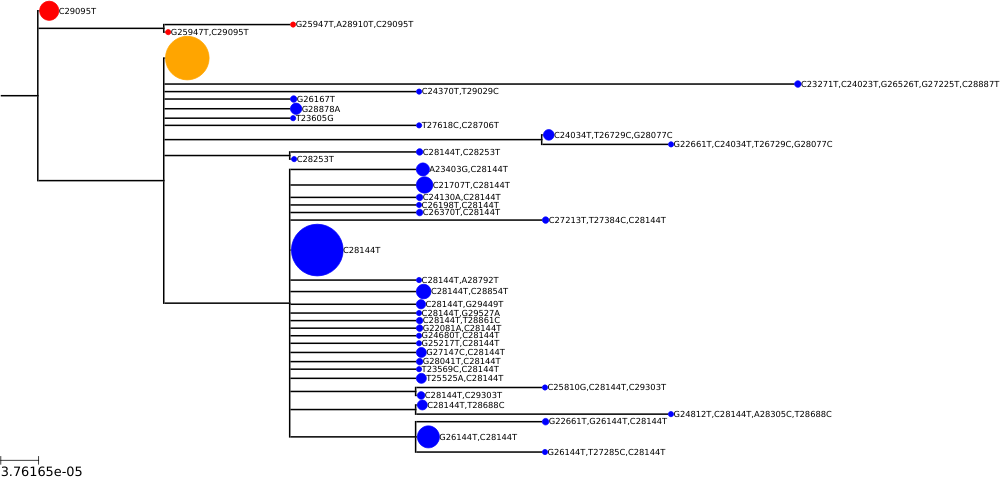


region, RpYN06
results/phylogenetics/region_RpYN06.treefile


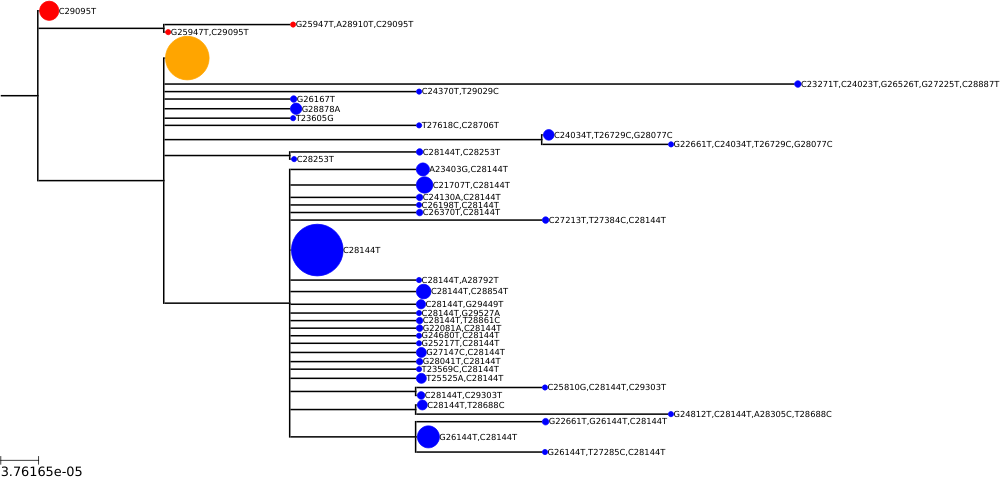


region, RmYN02
results/phylogenetics/region_RmYN02.treefile


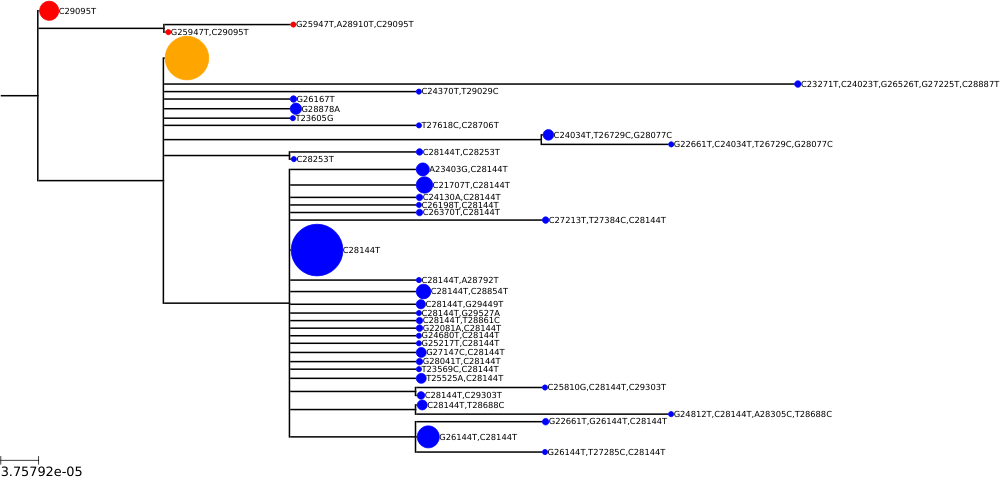

In [13]:
def get_pretty_tree(treefile,
                    df,
                    remove_outgroup=None,
                    widthscale=1000,
                    heightscale=1,
                    nodesizescale=5,
                    rootlength=0.05,
                    ):
    """Returns `(tree, tree_style)`."""
    t = ete3.Tree(treefile, format=1)
    t.ladderize()
    
    if remove_outgroup:
        outgroup_node = t.search_nodes(name=remove_outgroup)
        assert len(outgroup_node) == 1
        outgroup_node[0].delete()
    
    ts = ete3.TreeStyle()
    ts.show_leaf_name = False  # add tip names manually
    height = t.get_farthest_node()[1]
    ts.scale = widthscale / height
    ts.branch_vertical_margin = heightscale
    
    annotations = df.set_index('representative_strain').to_dict(orient='index')
    
    t.dist = rootlength * height
    
    for n in t.traverse():
        nstyle = ete3.NodeStyle()
        nstyle['hz_line_width'] = 2
        nstyle['vt_line_width'] = 2
        nstyle['hz_line_color'] = 'black'
        nstyle['vt_line_color'] = 'black'
        
        if n.is_leaf():
            nstyle['size'] = nodesizescale * math.sqrt(annotations[n.name]['nstrains'])
            n.add_face(ete3.TextFace(annotations[n.name]['substitutions'],
                                     tight_text=True,
                                     fsize=8,
                                     ),
                       column=0,
                       position='branch-right',
                       )
            if annotations[n.name]['nstrains'] == 1:
                nstyle['fgcolor'] = 'gray'
            elif 'T3171C' in annotations[n.name]['substitutions']:
                nstyle['fgcolor'] = 'purple'
            elif 'C29095T' in annotations[n.name]['substitutions']:
                nstyle['fgcolor'] = 'red'
            elif not annotations[n.name]['substitutions']:
                nstyle['fgcolor'] = 'orange'
            else:
                nstyle['fgcolor'] = 'blue'
            
        else:
            nstyle['size'] = 0
        
        n.set_style(nstyle)
    
    return t, ts


for (seqregion, outgroup), tree_file in tree_files.items():
    print(f"\n{seqregion}, {outgroup}")
    print(tree_file)
    t, ts = get_pretty_tree(tree_file,
                        seq_dfs[seqregion],
                        remove_outgroup=outgroup,
                        )
    display(t.render('%%inline', tree_style=ts, w=1000))

In [6]:
seq_dfs['all']

,substitutions,nstrains,representative_strain,all_strains,all_strains_dates
0,,9,hCoV-19/Hangzhou/ZJU-08/2020,"hCoV-19/Hangzhou/ZJU-08/2020, hCoV-19/USA/WA1/...","hCoV-19/Hangzhou/ZJU-08/2020 (2020-01-26), hCo..."
1,"A1079C,C5869T,T8782C,T18060C,C28144T",2,hCoV-19/Wuhan/0125-A152/2020,"hCoV-19/Wuhan/0125-A152/2020, hCoV-19/Wuhan/01...","hCoV-19/Wuhan/0125-A152/2020 (2020-01-25), hCo..."
2,"A1079C,T8782C,T18060C,C24130A,C28144T",2,hCoV-19/Wuhan/0125-A160/2020,"hCoV-19/Wuhan/0125-A160/2020, hCoV-19/Wuhan/01...","hCoV-19/Wuhan/0125-A160/2020 (2020-01-25), hCo..."
3,"A5084G,T8782C,T18060C,C28144T,C28854T",5,hCoV-19/Canada/ON_ON-VIDO-01-2/2020,"hCoV-19/Canada/ON_ON-VIDO-01-2/2020, hCoV-19/C...",hCoV-19/Canada/ON_ON-VIDO-01-2/2020 (2020-01-2...
4,"C1190T,T8782C,C9438T,G11083T,T18060C,C28144T",2,hCoV-19/France/IDF-0515-isl/2020,"hCoV-19/France/IDF-0515-isl/2020, hCoV-19/Fran...","hCoV-19/France/IDF-0515-isl/2020 (2020-01-29),..."
...,...,...,...,...,...
79,"T8782C,T18060C,G24680T,C28144T",2,hCoV-19/Jian/JX129/2020,"hCoV-19/Jian/JX129/2020, hCoV-19/Shandong/2020...","hCoV-19/Jian/JX129/2020 (2020-01-26), hCoV-19/..."
80,"T8782C,T18060C,G26144T,C28144T",22,hCoV-19/Sichuan/SC-WCH-311/2020,"hCoV-19/Sichuan/SC-WCH-311/2020, hCoV-19/Austr...","hCoV-19/Sichuan/SC-WCH-311/2020 (2020-01-27), ..."
81,"T8782C,T18060C,G27147C,C28144T",7,hCoV-19/Malaysia/MKAK-CL-2020-5047/2020,"hCoV-19/Malaysia/MKAK-CL-2020-5047/2020, hCoV-...",hCoV-19/Malaysia/MKAK-CL-2020-5047/2020 (2020-...
82,"T8782C,T18060C,T23569C,C28144T",2,hCoV-19/Guangdong/20SF014/2020,"hCoV-19/Guangdong/20SF014/2020, hCoV-19/Shenzh...","hCoV-19/Guangdong/20SF014/2020 (2020-01-15), h..."
